In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import List, Tuple

In [2]:
ROWS = 5
COLS = 5
type State = Tuple[int, int]
type Reward = int

Actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

class GridWorld:
    def __init__(self, rows=ROWS, cols=COLS):
        self._rows = rows
        self._cols = cols

        self._grid = np.array((rows, cols))
        self._terminal_states = [(0, 0), (rows-1, cols-1)]

    def get_actions(self, state: State) -> List[Tuple[int, State, Reward]]:
        if state in self._terminal_states:
            return []

        output = []
        for i, action in enumerate(Actions):
            new_r = state[0] + action[0]
            new_c = state[1] + action[1]

            new_state = (new_r, new_c)
            if self._is_valid_state(new_state):
                output.append((i, new_state, -1))
            else:
                output.append((i, state, -1))
        return output

    def _is_valid_state(self, state) -> bool:
        if 0 <= state[0] < self._rows and 0 <= state[1] < self._cols:
            return True
        return False

# Policy Evaluation

Iterative application of the state-value Bellman equation to converge on $v_\pi$, given some policy $\pi$. $\gamma$ is the discount factor, which helps in avoiding runaway negative loops by discounting future negative rewards. 

In [3]:
THRESHOLD = 1e-6
gridworld = GridWorld()

# rows * cols * 4 grid is a policy, each cell represents p(a|s)
type Policy = np.Array

equirandom = np.zeros((ROWS, COLS, 4)) + 0.25
equirandom[0, 0] = 0
equirandom[ROWS-1, COLS-1] = 0

def policy_evaluation_inplace(policy: Policy, gamma=0.99, threshold=THRESHOLD):
    V = np.zeros((ROWS, COLS))
    iterations = 0
    while True:
        delta = 0
        for r in range(ROWS):
            for c in range(COLS):
                old = V[r, c]
                actions = gridworld.get_actions((r, c))
                
                # the double sum from the bellman equation collapses here, since there is only one s',r for each action
                # and the probably of it = 1
                V[r,c] = sum([policy[r, c, action]*(reward + gamma*V[new_state]) for action, new_state, reward in actions])
                delta = max(delta, abs(old-V[r,c]))
        
        iterations += 1

        if delta < threshold:
            print(iterations)
            break
    return V


In [4]:
%%time
# LONG RUNNING CELL
# for grids larger than 100x100, this could take some time!
# test the policy evaluation on an equirandom policy
# policy_evaluation_inplace(equirandom)

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 8.34 μs


# Policy Improvement

Give a value function $V_\pi$ corresponding to some policy $\pi$, find the greedy policy $\pi'$, which is guaranteed to be at least equal to the original policy. The function also outputs a boolean which compares the new policy to the old one to determine if we truly improved the old one or not. If we have not improved the old policy, then the current policy is the optimal one. 

In [5]:
def policy_improvement(old_policy: Policy, V) -> Tuple[bool, Policy]:
    # select a deterministic policy that is greedy wrt V, given a deterministic old_policy
    new_policy = np.zeros((ROWS, COLS, 4))
    stable_policy = True
    for r in range(ROWS):
        for c in range(COLS):
            old_greedy = np.argmax(old_policy[r, c])
            
            actions = gridworld.get_actions((r, c))
            if not actions:
                continue
                                           
            one_step_value = {i: reward + V[new_state] for i, new_state, reward in actions}

            greedy_action = max(one_step_value, key=one_step_value.get)
            new_policy[r, c, greedy_action] = 1

            # make sure that we actually have something different. 
            # There can be multiple greedy actions, don't want to get stuck in a loop
            if abs(one_step_value[old_greedy] - one_step_value[greedy_action]) >= THRESHOLD:
                stable_policy = False

            
    return stable_policy, new_policy

            

# Policy Iteration with Naive Policy Evaluation

While we don't find a stable policy, we flip between policy evaluation and policy improvement. This is really expensive, because each pass of this process requires full convergence of a value function, which in itself requires sweeps of the state space. For grids larger than 100x100, this takes longer than 5 mins (I didn't wait haha).

In [6]:
def policy_iteration():
    # everything goes up, lol
    equirandom = np.zeros((ROWS, COLS, 4)) + 0.25
    equirandom[0, 0] = 0
    equirandom[ROWS-1, COLS-1] = 0
    
    V = policy_evaluation_inplace(equirandom)
    stable_policy = False
    policy = equirandom
    
    while not stable_policy:
        V = policy_evaluation_inplace(policy)
        print(V)
        stable_policy, policy = policy_improvement(policy, V)
        print("======")

    print("Done Policy Iteration!")
    print(policy)
    print(V)
    return V, policy
    

In [7]:
# policy_iteration()

# Value Iteration
Value Iteration is a more efficient version of the Policy Iteration, which only does one pass of policy evaluation before doing policy improvement. And this time, we use the Bellman Optimality equation in order to perform a greedy selection along the way. For a grid of 1000x1000, this completes in 5 minutes. 

When we visualize the value function, we notice that many of the middle values aren't even computed fully. This is because even if we do many more iterations, the optimal policy won't change - and since we're after the policy anyway, there's no point in fully completing the value function convergence!

In [8]:
def value_iteration(threshold=THRESHOLD):
    V = np.zeros((ROWS, COLS))
    iterations = 0
    while True:
        
        delta = 0

        for r in range(ROWS):
            for c in range(COLS):
                old = V[r, c]
                actions = gridworld.get_actions((r, c))
                if not actions:
                    continue
                # the double sum from the bellman equation collapses here, since there is only one s',r for each action
                V[r,c] = max([(reward + 0.9*V[new_state]) for _, new_state, reward in actions])
                delta = max(delta, abs(old-V[r,c]))
        
        iterations += 1

        if (iterations % 100 == 0):
            print(V)
        if delta < threshold:
            print(iterations)
            break

    zero_policy = np.zeros((ROWS, COLS, 4))
    _, policy = policy_improvement(zero_policy, V)
    return V, policy

In [35]:
%%time
values, policy = value_iteration()
policy = np.argmax(policy, axis=-1)

[[ 0.         -1.         -1.9        ... -9.99973439 -9.99973439
  -9.99973439]
 [-1.         -1.9        -2.71       ... -9.99973439 -9.99973439
  -9.99973439]
 [-1.9        -2.71       -3.439      ... -9.99973439 -9.99973439
  -9.99973439]
 ...
 [-9.99973439 -9.99973439 -9.99973439 ... -3.439      -2.71
  -1.9       ]
 [-9.99973439 -9.99973439 -9.99973439 ... -2.71       -1.9
  -1.        ]
 [-9.99973439 -9.99973439 -9.99973439 ... -1.9        -1.
   0.        ]]
133
CPU times: user 4min 4s, sys: 14.9 ms, total: 4min 4s
Wall time: 4min 4s


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
import seaborn as sns

def visualize_gridworld(values, policy, figsize=(10, 6)):
    """
    Visualize GridWorld value function and policy.
    
    Parameters:
    values: 2D numpy array of state values
    policy: 2D numpy array of actions (0: up, 1: right, 2: down, 3: left)
    figsize: tuple of figure dimensions
    """
    if not isinstance(values, np.ndarray):
        values = np.array(values)
    if not isinstance(policy, np.ndarray):
        policy = np.array(policy)

    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Value Function
    sns.heatmap(values, ax=ax1, cmap='Blues_r', annot=True, fmt='.2f', 
                cbar_kws={'label': 'Value'})
    ax1.set_title('Value Function')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Plot 2: Policy
    ax2.set_title('Optimal Policy')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    
    # Draw grid
    ax2.set_xticks(np.arange(COLS+1))
    ax2.set_yticks(np.arange(ROWS+1))
    ax2.set_yticklabels(range(ROWS, -1, -1))  # Reverse row numbers

    ax2.grid(True)
    ax2.set_xlim(0, COLS)
    ax2.set_ylim(0, ROWS)
    
    # Action to arrow mapping
    action_to_arrow = {
        0: (0, 0.4),    # Up
        1: (0.4, 0),    # Right
        2: (0, -0.4),   # Down
        3: (-0.4, 0)    # Left
    }
    
    # Draw arrows for policy
    for i in range(ROWS):
        for j in range(COLS):
            # Get the action for this cell
            action = policy[i, j]
            
            # Convert action to arrow direction
            dx, dy = action_to_arrow[action]
            
            # Calculate arrow center position
            center_x = j + 0.5  # center of cell horizontally
            center_y = ROWS - i - 0.5  # center of cell vertically
            
            # Create and add the arrow
            arrow = Arrow(center_x, center_y, dx, dy,
                        width=0.3, color='black')
            ax2.add_patch(arrow)
    
    plt.tight_layout()
    return fig


In [ ]:
#fig = visualize_gridworld(values, policy)


In [38]:
# the middle values are all -10, even though this is completely wrong, there are almost 500 steps left until one of the terminal steps!
# this demonstrates how little convergence value iteration actually needs in order to find an optimal policy. 
values[500]

array([-9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99999179,
       -9.99999179, -9.99999179, -9.99999179, -9.99999179, -9.99

# Recreating Cool Diagrams with small grid

226
226
[[  0.         -17.27489676 -25.55473925 -29.35830053 -30.7571451 ]
 [-17.27489676 -22.92752468 -27.0231337  -28.90880995 -29.35830141]
 [-25.55473925 -27.0231337  -27.75290237 -27.02313447 -25.55474073]
 [-29.35830053 -28.90880995 -27.02313447 -22.92752595 -17.27489819]
 [-30.7571451  -29.35830141 -25.55474073 -17.27489819   0.        ]]
4
[[ 0.       -1.       -1.99     -2.9701   -3.940399]
 [-1.       -1.99     -2.9701   -3.940399 -2.9701  ]
 [-1.99     -2.9701   -3.940399 -2.9701   -1.99    ]
 [-2.9701   -3.940399 -2.9701   -1.99     -1.      ]
 [-3.940399 -2.9701   -1.99     -1.        0.      ]]
Done Policy Iteration!
[[[0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]


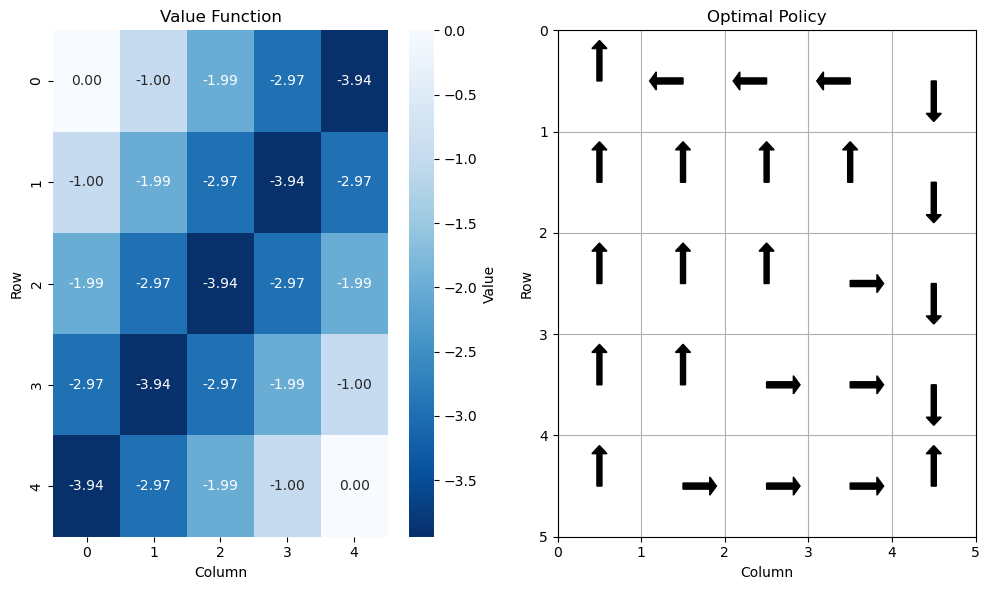

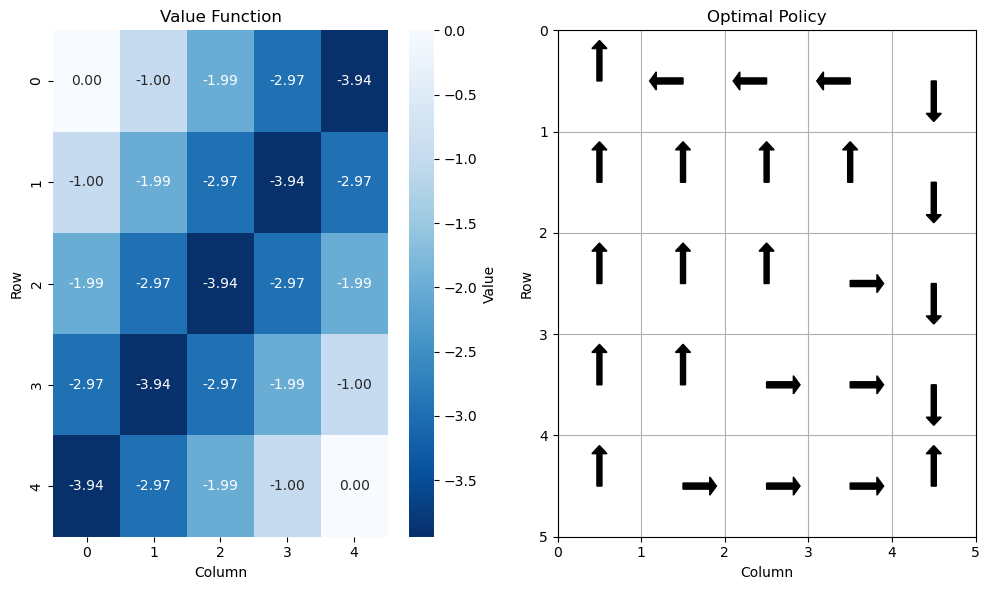

In [14]:
ROWS = 5
COLS = 5
values, policy = policy_iteration()

policy = np.argmax(policy, axis=-1)
visualize_gridworld(values, policy)